# Reconciling PCA and PPCA

PPCA is demeaned and standardized by default


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from ppca import PPCA

In [2]:
raw_returns = np.random.normal(0.005, 0.01, (120,20)) + 1.1*np.random.normal(0.01, 0.005, (120,1)) + 1.2*np.random.normal(0.01, 0.005, (120,1)) + np.random.normal(0.005, 0.01, (120,1)) + np.random.normal(0.005, 0.002, (120,1))

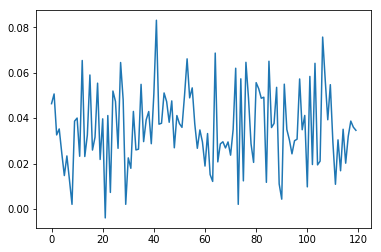

In [3]:
plt.plot(raw_returns[:,1])

In [4]:
raw_returns.shape

(120, 20)

In [5]:
scaler = StandardScaler()
scaler.fit(raw_returns)
returns = scaler.transform(raw_returns)

## Fit Both Models

In [6]:
n_comp = 3

In [7]:
mod = PCA(n_components=n_comp)
modp = PPCA()

In [8]:
mod.fit(returns)
modp.fit(returns, d=n_comp, tol=1e-5)

## Compare Betas

It's ok if signs don't match; that's a feature of PCA.

In [9]:
betas = mod.components_.T
betas.shape

(20, 3)

In [10]:
betasp = modp.C
betasp.shape

(20, 3)

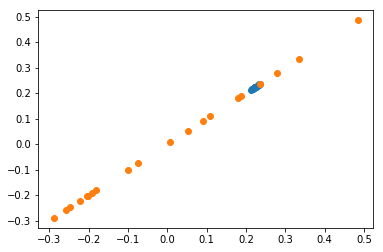

In [11]:
plt.scatter(betas[:,0], betasp[:,0]);
plt.scatter(betas[:,1], betasp[:,1]);

## Compare recovered factor returns

In [594]:
# for each factor, what is the return per date
factor_returns = mod.transform(returns)
factor_returns.shape

(120, 3)

In [595]:
factor_returnsp = modp.transform()
factor_returnsp.shape

(120, 3)

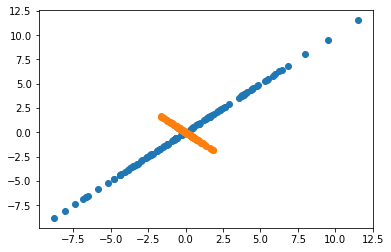

In [596]:
plt.scatter(factor_returns[:,0], factor_returnsp[:,0]);
plt.scatter(factor_returns[:,1], factor_returnsp[:,1]);

## Compare factor volatility

In [597]:
common_factor_volatility = np.std(factor_returns, axis=0)
common_factor_volatilityp = np.std(factor_returnsp, axis=0)

In [598]:
print(common_factor_volatility)
print(common_factor_volatilityp)

[3.74803076 0.74580423 0.7400688 ]
[3.74803076 0.74580176 0.7400645 ]


## Compare explained variance

In [599]:
mod.explained_variance_ratio_

array([0.70238673, 0.0278112 , 0.02738509])

In [600]:
np.diff(np.append(0, modp.var_exp))

array([0.70828914, 0.02804472, 0.0276149 ])

# Recover Common Returns (predicted returns)

In [533]:
# for each stock, what is the return attributable to all common factors for each date
common_returns = np.dot(factor_returns, betas.T)

In [534]:
common_returns.shape

(120, 20)

In [535]:
residuals = returns - common_returns

In [536]:
resid_volatility = np.std(residuals, axis=0)

### Inverse Transform to go from scaled space to original space

In [537]:
recons = scaler.inverse_transform(common_returns)

In [538]:
recons.shape

(120, 20)

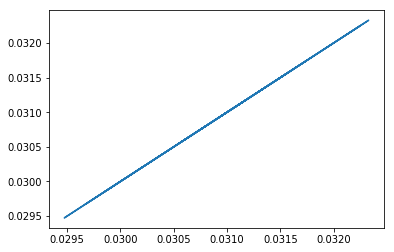

In [539]:
plt.plot(np.mean(recons, axis=0), np.mean(raw_returns, axis=0));

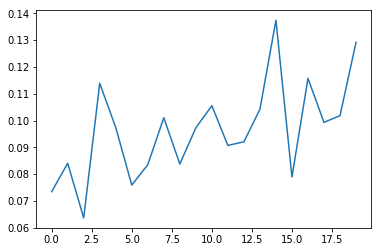

In [540]:
plt.plot((np.std(raw_returns, axis=0)-np.std(recons, axis=0))/np.std(raw_returns, axis=0))

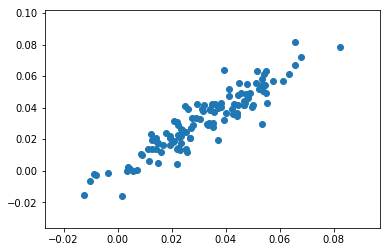

In [541]:
plt.scatter(recons[:,0], raw_returns[:,0])

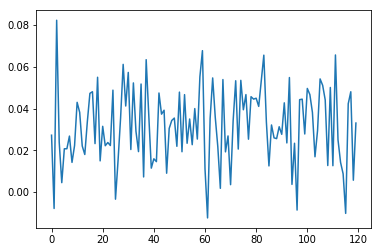

In [549]:
plt.plot(recons[:,0])

# PPCA Step By Step

In [181]:
raw_returns.shape

(120, 20)

In [182]:
scaler = StandardScaler()
scaler.fit(raw_returns)
returns = scaler.transform(raw_returns)

In [183]:
raw = returns

In [184]:
min_obs = 10   # we need this many samples for a column to be valid
d = 3          # number of dimensions we want reduced to

In [185]:
# set any infinite values to the maximum single value; np.isinf does not change np.nan items
raw[np.isinf(raw)] = np.max(raw[np.isfinite(raw)])


In [186]:
# find the columns that are valid

valid_series = np.sum(~np.isnan(raw), axis=0) >= min_obs

In [187]:
valid_series

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [188]:
data = raw[:, valid_series].copy()

In [189]:
N = data.shape[0]
D = data.shape[1]

In [190]:
observed = ~np.isnan(data)

In [191]:
observed

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [192]:
missing = np.sum(~observed)  # count of missing

In [193]:
# set all the nan's to zero
data[~observed] = 0

In [194]:
# initialize with random numbers
C = np.random.randn(D, d)    # these are the betas I think

In [195]:
CC = np.dot(C.T, C)

In [196]:
X = np.dot(np.dot(data, C), np.linalg.inv(CC))

In [197]:
reconst = np.dot(X, C.T)

In [198]:
reconst[~observed] = 0

In [199]:
sum_sq = np.sum((reconst - data)**2)/(N*D - missing)

In [200]:
v0 = np.inf
counter = 0

In [201]:
from scipy.linalg import orth

for i in np.arange(1,50):
    Sx = np.linalg.inv(np.eye(d) + CC/sum_sq)
    
    # e-step
    ss0 = sum_sq
    if missing > 0:   # if we have any missing data, project it from our current known betas and factor returns
        proj = np.dot(X, C.T)
        data[~observed] = proj[~observed]
    X = np.dot(np.dot(data, C), Sx)/ sum_sq

    # m-step
    XX = np.dot(X.T, X)
    C = np.dot(np.dot(data.T, X), np.linalg.pinv(XX + N*Sx))
    CC = np.dot(C.T, C)
    reconst = np.dot(X, C.T)
    reconst[~observed] = 0
    ss = (np.sum((reconst-data)**2) + N*np.sum(CC*Sx) + missing*ss0)/(N*D)
    
    # calc diff
    det = np.log(np.linalg.det(Sx))
    if np.isinf(det):
        det = abs(np.linalg.slogdet(Sx)[1])
    
    # trace is sum of diag
    v1 = N*(D*np.log(ss) + np.trace(Sx) - det) + np.trace(XX) - missing*np.log(ss0)
    diff = abs(v1/v0 - 1)
    counter += 1
    v0 = v1

print(C)
print(data)

C = orth(C)   # make orthnormal basis
print(C)

covmat = np.cov(np.dot(data, C).T) 

print(covmat)

vals, vecs = np.linalg.eig(covmat)
order = np.flipud(np.argsort(vals))
vecs = vecs[:, order]
vals = vals[order]

C = np.dot(C, vecs)

[[-0.02150492  0.5079911   0.67628206]
 [-0.02082786  0.49199737  0.65498982]
 [-0.02072448  0.4895555   0.65173899]
 [-0.02054025  0.48520356  0.64594531]
 [-0.02048523  0.48390383  0.64421499]
 [-0.02070666  0.48913439  0.65117837]
 [-0.02163598  0.5110869   0.68040346]
 [-0.02083183  0.49209123  0.65511477]
 [-0.0209784   0.49555351  0.65972406]
 [-0.02125682  0.50213031  0.66847967]
 [-0.02008275  0.47439637  0.63155783]
 [-0.02066371  0.48811984  0.64982771]
 [-0.01980392  0.46780987  0.6227893 ]
 [-0.02038977  0.48164888  0.641213  ]
 [-0.02032137  0.48003317  0.63906202]
 [-0.01999656  0.47236046  0.62884745]
 [-0.01977814  0.46720091  0.62197861]
 [-0.02058571  0.48627746  0.64737498]
 [-0.02053916  0.48517784  0.64591106]
 [-0.02173866  0.51351252  0.68363266]]
[[ 0.68409913  0.61336915 -0.85144902 ... -0.20547635  0.71162305
   0.12548436]
 [ 0.17617702  0.86257838  0.27557288 ...  1.3912325  -0.07717596
   0.29154601]
 [-0.11037744 -0.18899931 -0.89000641 ...  0.12665923 -0.

In [202]:
np.eye(d)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [203]:
CC

array([[ 0.00855054, -0.2019816 , -0.26889552],
       [-0.2019816 ,  4.7712265 ,  6.35187292],
       [-0.26889552,  6.35187292,  8.45616731]])